In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import math
import copy

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
data = pd.read_csv('seattleWeather_1948-2017.csv')
data.head(5)

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


# Initial Data Cleaning

In [4]:
data.isna().sum()

DATE    0
PRCP    3
TMAX    0
TMIN    0
RAIN    3
dtype: int64

In [5]:
data[(data.RAIN != True) & (data.RAIN!=False)]

,DATE,PRCP,TMAX,TMIN,RAIN
18415,1998-06-02,NaN,72,52,NaN
18416,1998-06-03,NaN,66,51,NaN
21067,2005-09-05,NaN,70,52,NaN


In [6]:
data = data[(data.RAIN == True) | (data.RAIN==False)]

In [7]:
labelencoder = LabelEncoder()
data['RAIN'] = labelencoder.fit_transform(data['RAIN'])

In [8]:
data['MONTH'] = pd.DatetimeIndex(data['DATE']).month
data['DAY'] = pd.DatetimeIndex(data['DATE']).day
data.head()

,DATE,PRCP,TMAX,TMIN,RAIN,MONTH,DAY
0,1948-01-01,0.47,51,42,1,1,1
1,1948-01-02,0.59,45,36,1,1,2
2,1948-01-03,0.42,45,35,1,1,3
3,1948-01-04,0.31,45,34,1,1,4
4,1948-01-05,0.17,45,32,1,1,5


# Preliminary Data Exploration

In [9]:
data.corr()

,PRCP,TMAX,TMIN,RAIN,MONTH,DAY
PRCP,1.000000,-0.226736,-0.064365,0.515160,0.014918,-0.001339
TMAX,-0.226736,1.000000,0.860675,-0.389241,0.154972,0.001726
TMIN,-0.064365,0.860675,1.000000,-0.139905,0.222504,0.003190
RAIN,0.515160,-0.389241,-0.139905,1.000000,-0.046046,-0.003148
MONTH,0.014918,0.154972,0.222504,-0.046046,1.000000,0.009639
DAY,-0.001339,0.001726,0.003190,-0.003148,0.009639,1.000000


None of these variable seems to have any correlation since all of the covariance is less 0.5

In [10]:
rain = data[data.RAIN == True]
norain = data[data.RAIN == False]

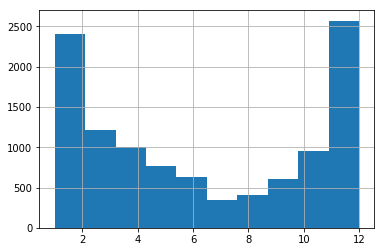

In [11]:
rain['MONTH'].hist()

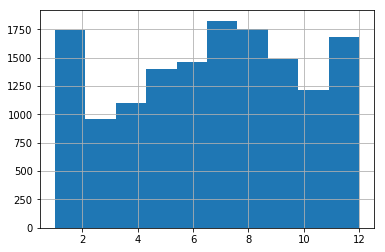

In [12]:
norain['MONTH'].hist()

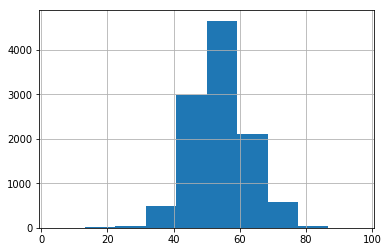

In [13]:
rain['TMAX'].hist()

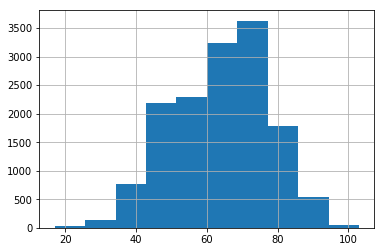

In [14]:
norain['TMAX'].hist()

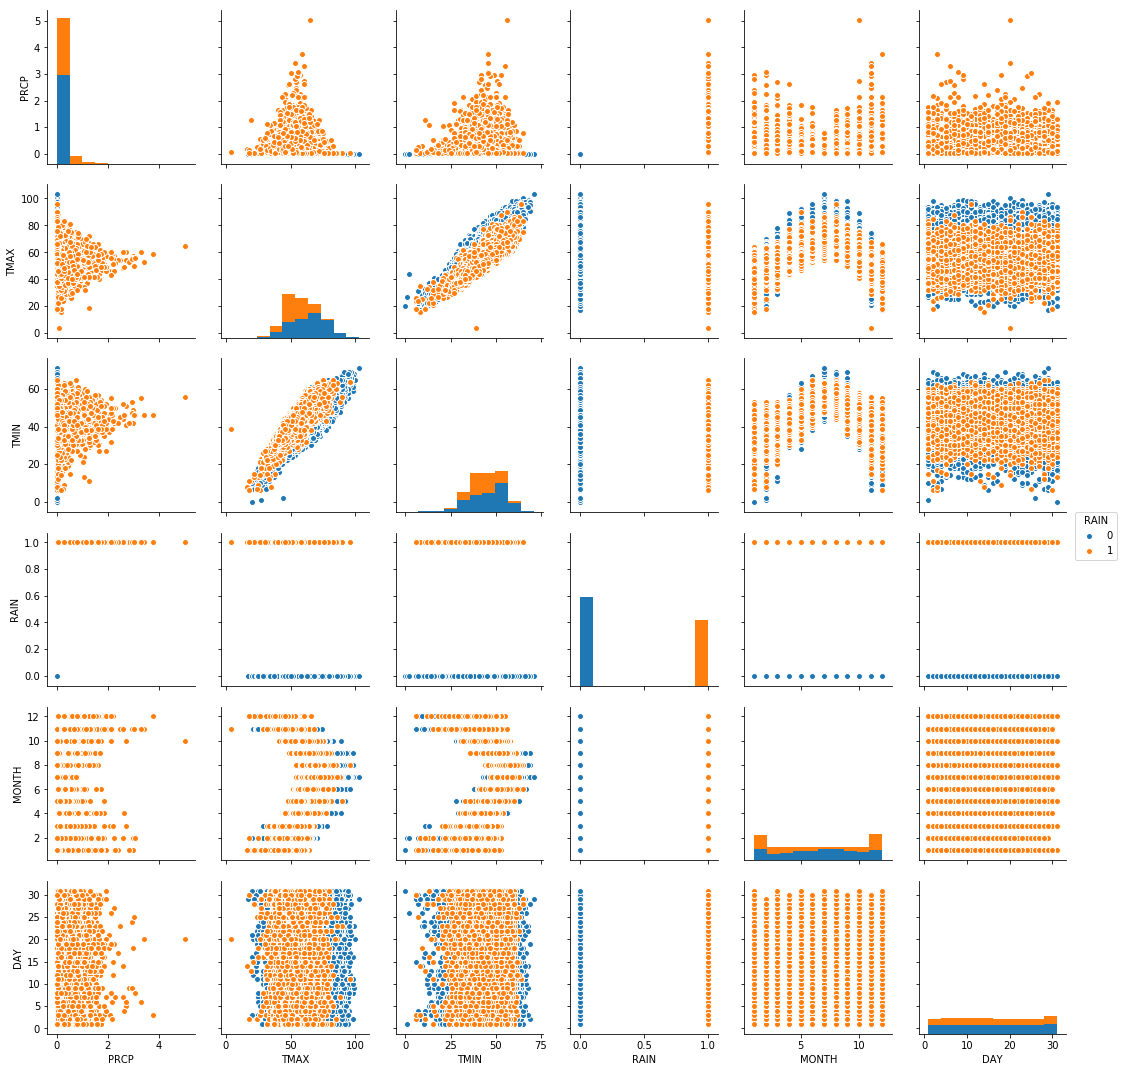

In [15]:
sns.pairplot(data, hue = 'RAIN')

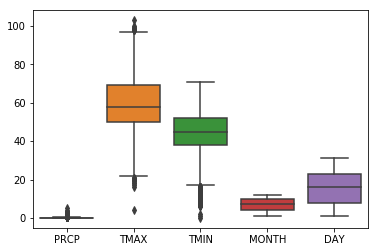

In [16]:
sns.boxplot(data=data[['PRCP','TMAX','TMIN','MONTH','DAY']])

There are some outliers in the graph, let see if we can take out the outliers by estimating the range of variable based on the box plots

In [17]:
dataN = data.copy()
dataN=dataN.drop(dataN[dataN['TMIN']<17 ].index)
dataN=dataN.drop(dataN[(dataN['TMAX']>97.5) | (dataN['TMAX']< 21.5)].index)
dataN=dataN.drop(dataN[(dataN['PRCP']>0.25) | (dataN['PRCP']< -0.15) ].index)

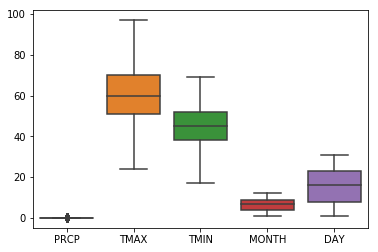

In [18]:
sns.boxplot(data=dataN[['PRCP','TMAX','TMIN','MONTH','DAY']])

We seem to have taken out of the outliers. We have also did some cleaning with the dataset as well.

# Cleaning

In [19]:
X = dataN[['PRCP','TMAX','TMIN','MONTH','DAY']].copy()
y = dataN['RAIN'].copy()

I did not use the dataN because I tried that out and it give a lower accuracy score, the original set of data with outliers seem to perform better with the models

# Transformation & Split

In [20]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)
scaler = StandardScaler()
Xscale = scaler.fit_transform(X)
XScaletrain,XScaletest,yscaletrain,yscaletest = train_test_split(Xscale,y,test_size=0.2)

In [21]:
# len(ytest[ytest == 1]) /len(ytest)

In [22]:
# len(ytest[ytest == 0]) / len(ytest)

# Analyze
    False Positive is type II error, where the hypothesis is false but we fail to reject it.
    False Negative is type I error, where the hypothesis is true but we reject it.
    The common norm is that type I is worse than type II.

## SVM

array([0, 0, 0, ..., 0, 0, 0])

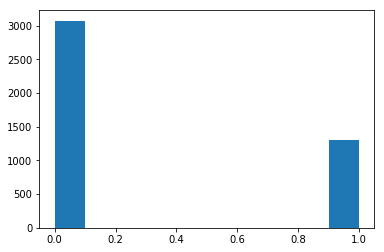

In [23]:
svc = SVC()
svc.fit(Xtrain,ytrain)
ypredS = svc.predict(Xtest)
plt.hist(ypredS)
ypredS

In [24]:
metrics.accuracy_score(ytest,ypredS)

0.7560529922338968

In [25]:
metrics.confusion_matrix(ytest,ypredS)
# TruePositive FalsePositive
# FalseNegative TrueNegative

array([[2463,  459],
       [ 609,  847]])

In [26]:
# sns.heatmap(metrics.confusion_matrix(ytest, ypredS) / len(ytest), cmap='Blues', annot=True)

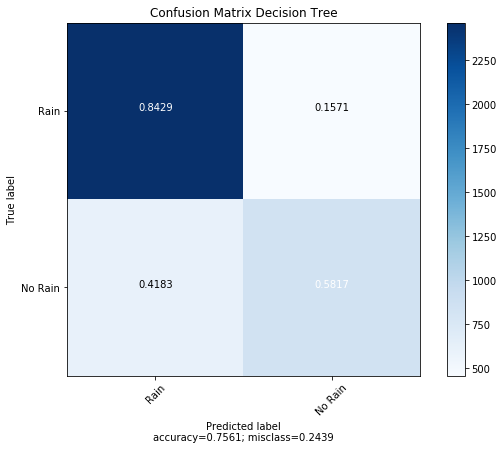

In [27]:
plot_confusion_matrix(cm = metrics.confusion_matrix(ytest, ypredS),normalize=True, target_names = ['Rain', 'No Rain'],title = "Confusion Matrix Decision Tree")

In [28]:
metrics.roc_auc_score(ytest,ypredS)

0.7123232901595324

In [29]:
svc = SVC()
svc.fit(XScaletrain,yscaletrain)
ypredscale = svc.predict(XScaletest)
metrics.accuracy_score(yscaletest,ypredscale)

0.9993147555961627

In [30]:
metrics.roc_auc_score(yscaletest,ypredscale)

0.9989912575655683

In [31]:
metrics.confusion_matrix(yscaletest,ypredscale)

array([[2891,    0],
       [   3, 1484]])

In [32]:
# sns.heatmap(metrics.confusion_matrix(yscaletest, ypredscale) / len(ytest), cmap='Blues', annot=True)

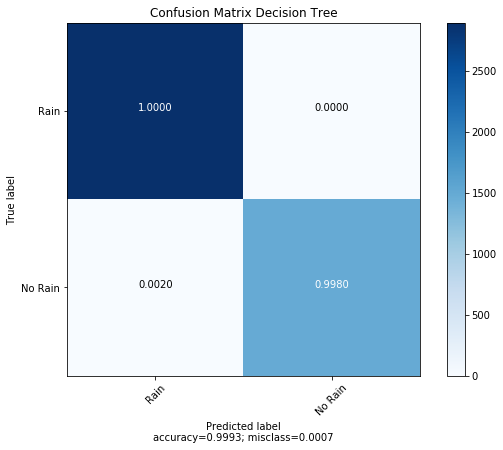

In [33]:
plot_confusion_matrix(cm = metrics.confusion_matrix(yscaletest, ypredscale),normalize=True, target_names = ['Rain', 'No Rain'],title = "Confusion Matrix Decision Tree")

Scaling seem to improve the the accuracy

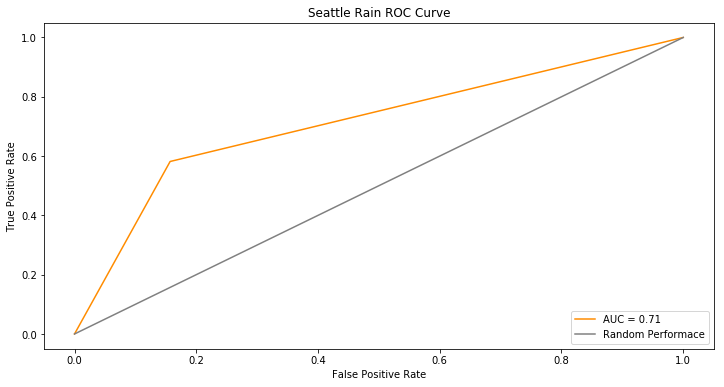

In [34]:
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredS)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', label='Random Performace')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Seattle Rain ROC Curve')
plt.legend(loc="lower right")

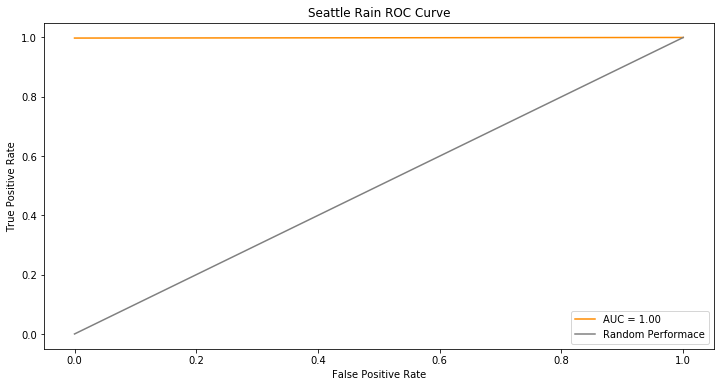

In [35]:
fpr, tpr, threshold = metrics.roc_curve(yscaletest, ypredscale)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', label='Random Performace')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Seattle Rain ROC Curve')
plt.legend(loc="lower right")

Scaling helps improve the performance of the test

## Logistic regression

(array([3243.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1135.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

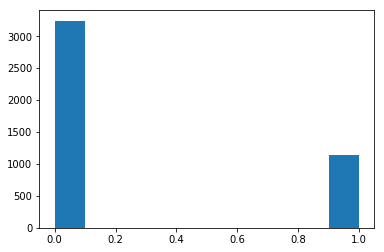

In [36]:
lr = LogisticRegression()
lr.fit(Xtrain,ytrain)
ypredL = lr.predict(Xtest)
plt.hist(ypredL)

In [37]:
metrics.accuracy_score(ytest,ypredL)

0.9207400639561444

In [38]:
metrics.confusion_matrix(ytest,ypredL)
# TruePositive FalsePositive
# FalseNegative TrueNegative

array([[2909,   13],
       [ 334, 1122]])

In [39]:
# sns.heatmap(metrics.confusion_matrix(ytest, ypredL) / len(ytest), cmap='Blues', annot=True)

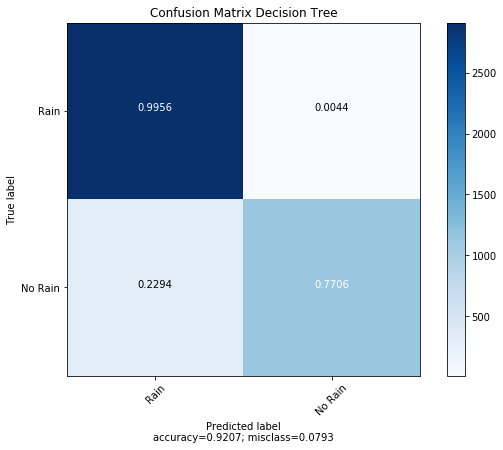

In [40]:
plot_confusion_matrix(cm = metrics.confusion_matrix(ytest,ypredL),normalize=True, target_names = ['Rain', 'No Rain'],title = "Confusion Matrix Decision Tree")

In [41]:
metrics.roc_auc_score(ytest,ypredL)

0.883077694037653

In [42]:
lr = LogisticRegression()
lr.fit(XScaletrain,yscaletrain)
ypredscale = lr.predict(XScaletest)
metrics.accuracy_score(yscaletest,ypredscale)

0.9990863407948835

In [43]:
metrics.roc_auc_score(yscaletest,ypredscale)

0.9986550100874243

In [44]:
metrics.confusion_matrix(yscaletest,ypredscale)

array([[2891,    0],
       [   4, 1483]])

In [45]:
# sns.heatmap(metrics.confusion_matrix(yscaletest, ypredscale) / len(ytest), cmap='Blues', annot=True)

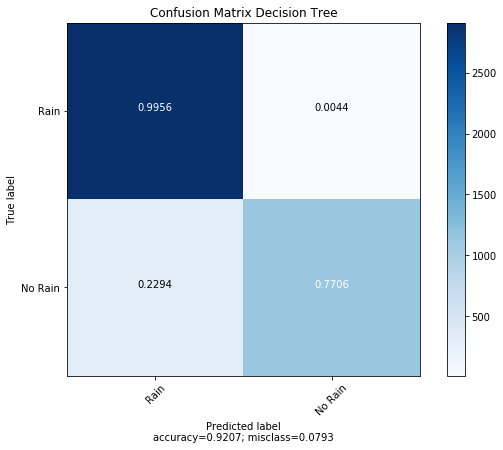

In [46]:
plot_confusion_matrix(cm = metrics.confusion_matrix(ytest,ypredL),normalize=True, target_names = ['Rain', 'No Rain'],title = "Confusion Matrix Decision Tree")

Scaling does help a bit but not a ton

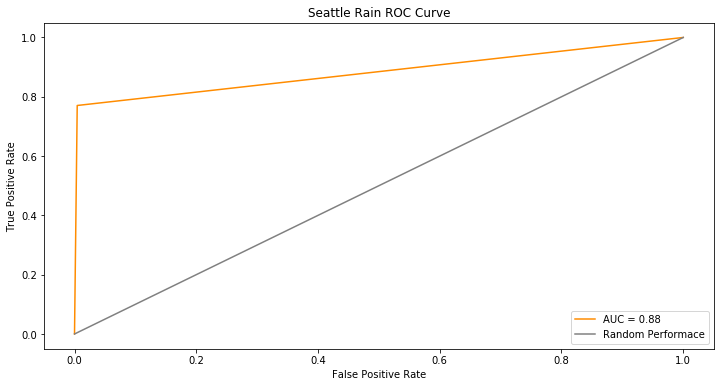

In [47]:
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredL)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', label='Random Performace')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Seattle Rain ROC Curve')
plt.legend(loc="lower right")

## Naive Bayes

(array([2922.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1456.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

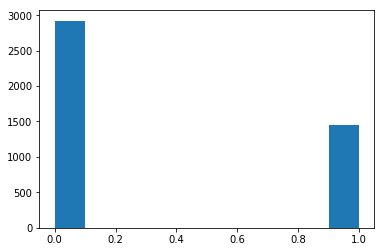

In [48]:
naive = GaussianNB()
naive.fit(Xtrain,ytrain)
ypredB = naive.predict(Xtest)
plt.hist(ypredB)

In [49]:
metrics.accuracy_score(ytest,ypredB)

1.0

In [50]:
metrics.confusion_matrix(ytest,ypredB)

array([[2922,    0],
       [   0, 1456]])

In [51]:
# sns.heatmap(metrics.confusion_matrix(ytest, ypredB) / len(ytest), cmap='Blues', annot=True)

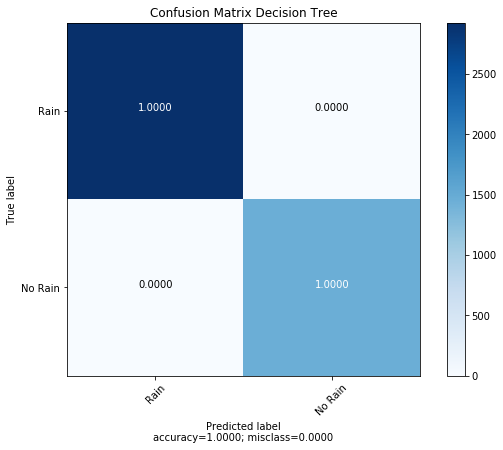

In [52]:
plot_confusion_matrix(cm = metrics.confusion_matrix(ytest,ypredB),normalize=True, target_names = ['Rain', 'No Rain'],title = "Confusion Matrix Decision Tree")

In [53]:
metrics.roc_auc_score(ytest,ypredB)

1.0

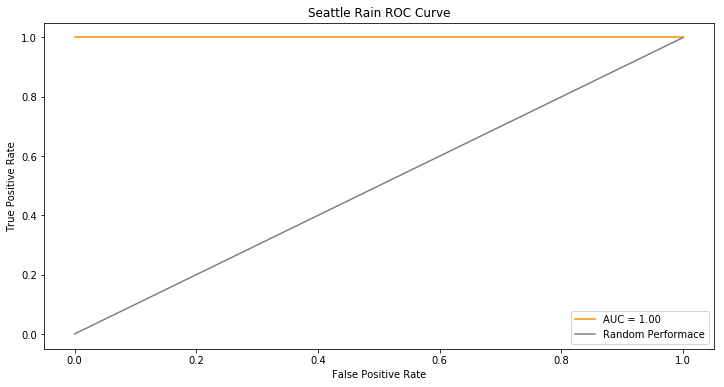

In [54]:
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredB)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', label='Random Performace')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Seattle Rain ROC Curve')
plt.legend(loc="lower right")

In [55]:
naive = GaussianNB()
naive.fit(XScaletrain,yscaletrain)
ypredscale = naive.predict(XScaletest)
metrics.accuracy_score(yscaletest,ypredscale)

1.0

Scaling does not impact the performance

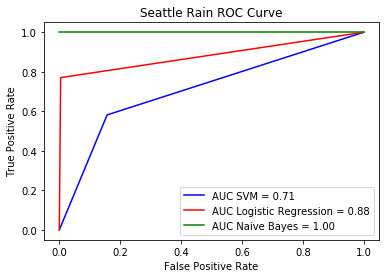

In [56]:
ypred = [ypredS,ypredL,ypredB]
test = ['SVM','Logistic Regression', 'Naive Bayes']
colors = ['blue','red','green']
for i in range(1, 4):
    fpr, tpr, threshold = metrics.roc_curve(ytest, ypred[i-1])
    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, color=colors[i-1], label = 'AUC '+test[i-1]+' = %0.2f' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Seattle Rain ROC Curve')
    plt.legend(loc="lower right")

# We can see that the precipitation may impact the prediction of rain since it has a high corelation. Therefore, we would try dropping this parameter to see how it model perform

In [57]:
newdata = dataN.drop(['PRCP'], axis=1)
newdata.head()

,DATE,TMAX,TMIN,RAIN,MONTH,DAY
4,1948-01-05,45,32,1,1,5
7,1948-01-08,48,35,1,1,8
8,1948-01-09,50,31,1,1,9
10,1948-01-11,42,32,1,1,11
11,1948-01-12,41,26,0,1,12


In [58]:
X = newdata[['TMAX','TMIN','MONTH','DAY']]
y = newdata['RAIN']
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)
scaler = StandardScaler()
Xscale = scaler.fit_transform(X)
XScaletrain,XScaletest,yscaletrain,yscaletest = train_test_split(Xscale,y,test_size=0.2)

## Naive Bayes

In [59]:
#without scaling
naive2 = GaussianNB()
naive2.fit(Xtrain,ytrain)
ypredN = naive2.predict(Xtest)

In [60]:
metrics.accuracy_score(ytest,ypredN)

0.6637734125171311

In [61]:
metrics.roc_auc_score(ytest,ypredN)

0.6486130785961655

In [62]:
#with scaling
naive2 = GaussianNB()
naive2.fit(XScaletrain,yscaletrain)
yscalepredN = naive2.predict(XScaletest)

In [63]:
metrics.accuracy_score(yscaletest,yscalepredN)

0.6484696208314299

In [64]:
metrics.roc_auc_score(yscaletest,yscalepredN)

0.6310680211707145

## Logistic Regression

In [65]:
#without scaling
lr = LogisticRegression()
lr.fit(Xtrain,ytrain)
ypredL = lr.predict(Xtest)

In [66]:
metrics.accuracy_score(ytest,ypredL)

0.7466879853814528

In [67]:
metrics.roc_auc_score(ytest,ypredL)

0.6905656518552904

In [68]:
#with scaling
lr = LogisticRegression()
lr.fit(XScaletrain,yscaletrain)
yscalepredL = lr.predict(XScaletest)

In [69]:
metrics.accuracy_score(yscaletest,yscalepredL)

0.7494289629968022

In [70]:
metrics.roc_auc_score(yscaletest,yscalepredL)

0.6976968113552947

## SVM

In [71]:
# without scaling
svm = SVC()
svm.fit(Xtrain,ytrain)
ypredS = svm.predict(Xtest)

In [72]:
metrics.accuracy_score(ytest,ypredS)

0.751027866605756

In [73]:
metrics.roc_auc_score(ytest,ypredS)

0.6984482325037845

In [74]:
#with scaling
svm = SVC()
svm.fit(XScaletrain,yscaletrain)
yscalepredS = svm.predict(XScaletest)

In [75]:
metrics.accuracy_score(yscaletest,yscalepredS)

0.7533120146185472

In [76]:
metrics.roc_auc_score(yscaletest,yscalepredS)

0.7011256358712675

## Decision Tree

In [97]:
from sklearn.tree import DecisionTreeClassifier
# without scaling
model_tree = DecisionTreeClassifier(max_depth=5)
model_tree=model_tree.fit(Xtrain,ytrain)
ypredT = model_tree.predict(Xtest)

In [98]:
metrics.accuracy_score(ytest,ypredT)

0.7466879853814528

In [99]:
# with scaling 
model_tree = DecisionTreeClassifier(max_depth=5)
model_tree=model_tree.fit(XScaletrain,yscaletrain)
yscalepredT = model_tree.predict(XScaletest)
metrics.accuracy_score(yscaletest,yscalepredT)

0.7448606669712198

## Note: Scaling does not really help in this situation and once we drop precipitation, we can see that the model perform worse since precipitation, in this case, directly related to rain
Next step: try PCA to standardize the data to see whether the models have better performances. Also maybe try KMeans to see if it can predict the clustering 

In [100]:
from sklearn.decomposition import PCA
pca = PCA()
X = pca.fit_transform(X)
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)
scaler = StandardScaler()
Xscale = scaler.fit_transform(X)
XScaletrain,XScaletest,yscaletrain,yscaletest = train_test_split(Xscale,y,test_size=0.2)

In [104]:
# logistic Regression
lr = LogisticRegression()
lr.fit(Xtrain,ytrain)
ypredL = lr.predict(Xtest)

In [105]:
metrics.accuracy_score(ytest,ypredL)

0.7626770214709914

In [106]:
# Support vector machine
svm = SVC()
svm.fit(Xtrain,ytrain)
ypredS = svm.predict(Xtest)

In [107]:
metrics.accuracy_score(ytest,ypredS)

0.7501142074006396

## PCA does not seem to help in term of increasing the accuracy of the predictive model

In [108]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=5)
kmeans.fit(Xtrain,ytrain)
ypred = kmeans.predict(Xtest)

In [110]:
metrics.accuracy_score(ytest,ypred)

0.3732297852900868

## Kmeans perform horribly, this is probably because it is not supervised.
Next step, try undersampling to get a balance data set between rain and not-rain

In [120]:
rain = len(newdata[newdata['RAIN'] == 1])

In [121]:
rainIndices = newdata[newdata['RAIN'] == 0].index
random_indices = np.random.choice(rainIndices,rain, replace=False)

In [122]:
norain = newdata[newdata['RAIN'] == 1].index
under_sample_indices = np.concatenate([norain,random_indices])

In [123]:
under_sample = newdata.loc[under_sample_indices]

In [126]:
under_sample.groupby('RAIN').count()

,DATE,TMAX,TMIN,MONTH,DAY
RAIN,,,,,
0,7324,7324,7324,7324,7324
1,7324,7324,7324,7324,7324


In [127]:
X = under_sample[['TMAX','TMIN','MONTH','DAY']]
y = under_sample['RAIN']
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)
scaler = StandardScaler()
Xscale = scaler.fit_transform(X)
XScaletrain,XScaletest,yscaletrain,yscaletest = train_test_split(Xscale,y,test_size=0.2)

In [139]:
# SVC
svm = SVC()
svm.fit(XScaletrain,yscaletrain)
ypredS = svm.predict(XScaletest)
metrics.accuracy_score(yscaletest,ypredS)
metrics.classification_report(yscaletest,ypredS)

'             precision    recall  f1-score   support\n\n          0       0.81      0.65      0.72      1477\n          1       0.70      0.85      0.77      1453\n\navg / total       0.76      0.75      0.75      2930\n'

In [133]:
svm = SVC()
svm.fit(Xtrain,ytrain)
ypredS = svm.predict(Xtest)
metrics.accuracy_score(ytest,ypredS)

0.7310580204778157

In [134]:
# Logistic regression
lr = LogisticRegression()
lr.fit(Xtrain,ytrain)
ypredL = lr.predict(Xtest)
metrics.accuracy_score(ytest,ypredL)

0.7399317406143344

In [135]:
lr = LogisticRegression()
lr.fit(XScaletrain,yscaletrain)
ypredL = lr.predict(XScaletest)
metrics.accuracy_score(yscaletest,ypredL)

0.7419795221843003

In [137]:
# Decision Tree
model_tree = DecisionTreeClassifier(max_depth=5)
model_tree=model_tree.fit(Xtrain,ytrain)
ypredT = model_tree.predict(Xtest)
metrics.accuracy_score(ytest,ypredT)

0.7331058020477815

In [138]:
model_tree = DecisionTreeClassifier(max_depth=5)
model_tree=model_tree.fit(XScaletrain,yscaletrain)
ypredT = model_tree.predict(XScaletest)
metrics.accuracy_score(yscaletest,ypredT)

0.741296928327645

## Final words: without precipitation, highest score we have for prediction is 74%, which are from logistic regression and decision tree after we scale the data and underperform it to get a more balance data set.